### SNA & MDS

In [1]:
import operator
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']

In [3]:
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.manifold import MDS
from pygsp import graphs

In [4]:
import nltk
from nltk import bigrams
import collections

In [5]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [6]:
# Files definition
comment_bow = 'output\cooc_bow_all.csv'
comment_jacc = 'output\comment_cooc_jacc.xlsx' # Similarity measure

In [7]:
brands = ['เมจิ','ดัชมิลล์','โฟร์โมสต์','แดรี่โฮม','โชคชัย','เอ็มมิลค์','ไทยเดนมาร์ค']

เปิดไฟล์ที่ได้จากขั้นตอน Data Prep

In [8]:
cooc_matrix_bow = pd.read_csv(comment_bow,index_col=0)
cooc_matrix_jacc= pd.read_excel(comment_jacc,index_col=0)

In [9]:
cooc_matrix_bow.shape

(8432, 338)

In [10]:
matrix_freq_brand = cooc_matrix_bow[brands]
matrix_freq_unbrand = cooc_matrix_bow.drop(labels=brands,axis=1,inplace=False)

### MDS Visualization

In [11]:
# https://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html

In [12]:
def jaccard_precompute(df_b, df_attr , i, j, k):
    brand1 = pd.DataFrame(df_b.iloc[:,i])
    brand2 = pd.DataFrame(df_b.iloc[:,j])
    attr = pd.DataFrame(df_attr.iloc[:,k])
    slice_df = pd.concat([brand1, attr, brand2], axis=1, join="inner")
    a_in_b = slice_df[(slice_df.iloc[:,0]>0)&(slice_df.iloc[:,1]>0)&(slice_df.iloc[:,2]>0)]
    a_occur = slice_df[(slice_df.iloc[:,0]>0)&(slice_df.iloc[:,1]>0)]
    b_occur = slice_df[(slice_df.iloc[:,2]>0)&(slice_df.iloc[:,1]>0)]
    jacc_index = a_in_b.shape[0]/(a_occur.shape[0]+b_occur.shape[0]-a_in_b.shape[0])
    return jacc_index

In [13]:
def create_MDS_perceptual_map(df, attrName, dissim):
    embedding = MDS(n_components=2, dissimilarity=dissim)
    mds_coord = embedding.fit_transform(df)
    fig, ax=plt.subplots(figsize=(10,5))
    ax.set_title(f'MDS Perceptual map: {attrName}', fontsize=20)
    plt.scatter(mds_coord[:,0],mds_coord[:,1])
    labels=df.index
    for label,x,y in zip(labels, mds_coord[:,0], mds_coord[:,1]):
        plt.annotate(label,(x,y), fontsize=13)
    plt.axhline(y=0, color='k', linestyle='-', linewidth=1)
    plt.axvline(x=0, color='k', linestyle='-', linewidth=1)
    plt.xlabel('PC1', fontsize=16)
    plt.ylabel('PC2', fontsize=16)
    plt.grid(True)
    plt.show()
    return mds_coord.shape, embedding

In [14]:
# Co-occurrence dissimilarity (distance = 1-index) ใช้กับ MDS (อย่าใช้ similarity)
def gen_precomputed_matrix(df_b, df_attr):
    precomputed_matrix = pd.DataFrame(index=df_b.columns,columns=df_b.columns).fillna(0)
    
    jacc = pd.DataFrame(columns=df_attr.columns)
    jacc = jacc.append(pd.Series([],dtype='float64'), ignore_index=True).fillna(0.0)
    
    for i in range(0,len(precomputed_matrix.columns)):
        for j in range(0,len(precomputed_matrix.columns)):
            for k in range(0,len(df_attr.columns)): # 0 to 329
                try:
                    jacc.iloc[0,k] = 1-jaccard_precompute(df_b, df_attr,i, j, k)
                except Exception:
                    jacc.iloc[0,k] = None
                    continue
            precomputed_matrix.iloc[i,j] = jacc.mean(axis=1)[0]
            jacc = jacc.iloc[0:0].append(pd.Series([],dtype='float64'), ignore_index=True).fillna(0.0)
    return precomputed_matrix

In [15]:
# Transpose frequency into Attribute Rating Format for Euclidean distance MDS
#cooc_matrix_freq = cooc_matrix_freq[brands].T
#cooc_matrix_freq.drop(axis=1, columns=brands, inplace=True)

# Transpose frequency into Attribute Rating Format for precompute MDS
#cooc_matrix_freq = cooc_matrix_freq[brands]
#cooc_matrix_freq.drop(brands, axis=0, inplace=True)
#cooc_matrix_freq = cooc_matrix_freq.T

In [16]:
dissim = ['euclidean', 'precomputed']
promotions = ['แจก','แชร์','แถม','แพคคู่','โฆษณา','โปรโมชั่น','การลดราคา','ชิม','รีวิว','ลดราคา']
mixtures = ['เวย์','เวย์โปรตีน','แคลเซียม','แคลเซี่ยม','แมกนีเซียม','แลกโตส','แล็กโต๊ส','แลคโตส','แลคติก','โซเดียม','โปรตีน','โพแทสเซียม','โฟเลต','โฟลิค'
                  ,'ไขมัน','ไขมัน 0%','ไขมันต่ำ','กรดไขมัน','กรดอะมิโน','กลูโคส','คาร์โบไฮเดรต','ธาตุเหล็ก','นมข้น','นมผง','นมวัว','น้ำ','น้ำเชื่อม','น้ำตาล','น้ำตาลเทียม'
                  ,'น้ำตาลทราย','น้ำตาลทรายแดง','น้ำนม','น้ำผึ้ง','ปริมาณ','ผสม','วิตามิน','ส่วนผสม','สูตร']

In [17]:
precomMat_promotion = gen_precomputed_matrix(matrix_freq_brand,matrix_freq_unbrand[promotions])
precomMat_mixtures = gen_precomputed_matrix(matrix_freq_brand,matrix_freq_unbrand[mixtures])
precomMat_overall = gen_precomputed_matrix(matrix_freq_brand,matrix_freq_unbrand)

In [18]:
precomMat_overall

,เมจิ,ดัชมิลล์,โฟร์โมสต์,แดรี่โฮม,โชคชัย,เอ็มมิลค์,ไทยเดนมาร์ค
เมจิ,0.000000,0.889197,0.905533,0.980437,0.970354,0.959829,0.949960
ดัชมิลล์,0.889197,0.000000,0.875328,0.978107,0.958265,0.999545,0.888589
โฟร์โมสต์,0.905533,0.875328,0.000000,1.000000,0.964530,0.999742,0.882579
แดรี่โฮม,0.980437,0.978107,1.000000,0.000000,0.986536,0.996212,0.957340
โชคชัย,0.970354,0.958265,0.964530,0.986536,0.000000,1.000000,0.975124
เอ็มมิลค์,0.959829,0.999545,0.999742,0.996212,1.000000,0.000000,0.999952
ไทยเดนมาร์ค,0.949960,0.888589,0.882579,0.957340,0.975124,0.999952,0.000000


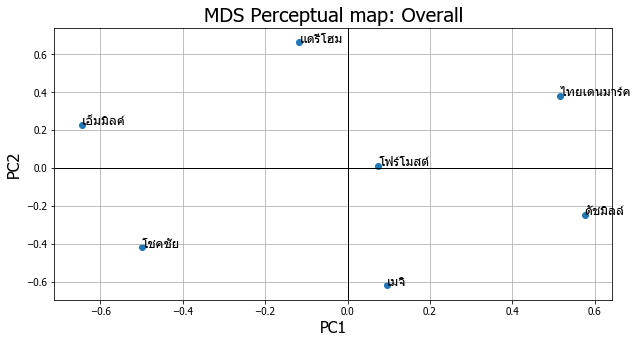

((7, 2), MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
     n_components=2, n_init=4, n_jobs=None, random_state=None, verbose=0))

In [19]:
create_MDS_perceptual_map(precomMat_overall,'Overall', dissim[1])

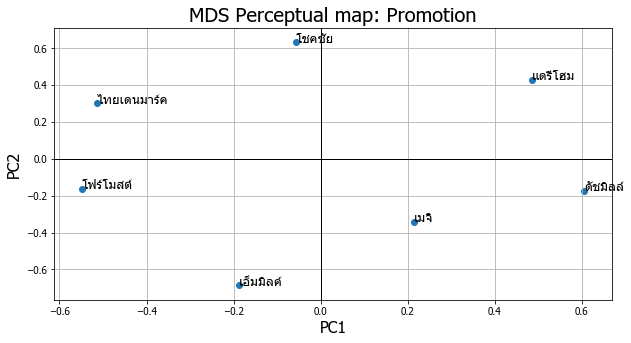

((7, 2), MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
     n_components=2, n_init=4, n_jobs=None, random_state=None, verbose=0))

In [20]:
create_MDS_perceptual_map(precomMat_promotion,'Promotion', dissim[1])

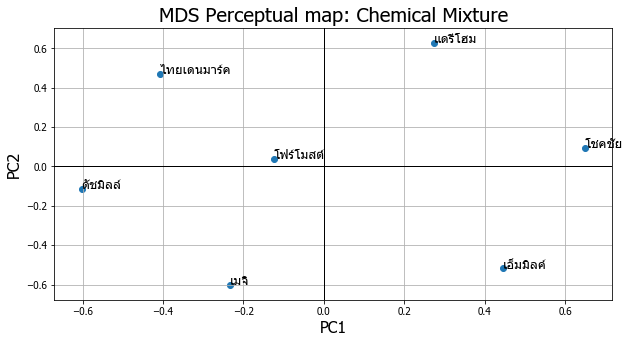

((7, 2), MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
     n_components=2, n_init=4, n_jobs=None, random_state=None, verbose=0))

In [21]:
create_MDS_perceptual_map(precomMat_mixtures,'Chemical Mixture', dissim[1])

สร้างกราฟ

In [22]:
def stackForGraph(cm):
    stack_matrix = pd.DataFrame(cm.stack())
    stack_matrix.index.names = ['item', 'relatedItem']
    stack_matrix.columns = ['coocValue']
    stack_matrix.reset_index(inplace=True)
    stack_matrix = stack_matrix[(stack_matrix.item != stack_matrix.relatedItem)]
    stack_matrix.sort_values(by='coocValue',ascending=False).head(10)
    return stack_matrix

In [23]:
def plot_pandas_graph(df):
    fig, ax=plt.subplots(figsize=(15,8))
    G=nx.from_pandas_edgelist(df,source='item',target='relatedItem')
    nx.draw(G,with_labels=True, font_family='Tahoma',node_color='yellow')
    plt.show()
    return G

In [24]:
def create_upperTriMatrix(df):
    df.values[np.tril(np.ones(df.shape)).astype(np.bool)] = 0
    return df

Upper matrix plot (Co-occurence without normalization)

In [25]:
#cooc_matrix_ = create_upperTriMatrix(cooc_matrix)
#cooc_matrix_2 = stackForGraph(cooc_matrix_)

cooc_matrix_2 = stackForGraph(cooc_matrix_jacc)
cooc_matrix_2_filter = cooc_matrix_2[(cooc_matrix_2.coocValue >= 0.01)&(cooc_matrix_2.item.isin(brands))]
#cooc_matrix_2_filter = cooc_matrix_2[(cooc_matrix_2.coocValue >= 0.4)]

In [26]:
cooc_matrix_2.tail(10)

,item,relatedItem,coocValue
114233,โด๊บ,สัปปะรด,0.0
114234,โด๊บ,แมกนีเซียม,0.0
114235,โด๊บ,โรคท้องร่วง,0.0
114236,โด๊บ,สยามพารากอน,0.0
114237,โด๊บ,ห้างร้าน,0.0
114238,โด๊บ,โรคขาดอาหาร,0.0
114239,โด๊บ,ช่องแช่แข็ง,0.0
114240,โด๊บ,โยเกิร์ท,0.0
114241,โด๊บ,พารากอน,0.0
114242,โด๊บ,พาราไดซ์,0.0


C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


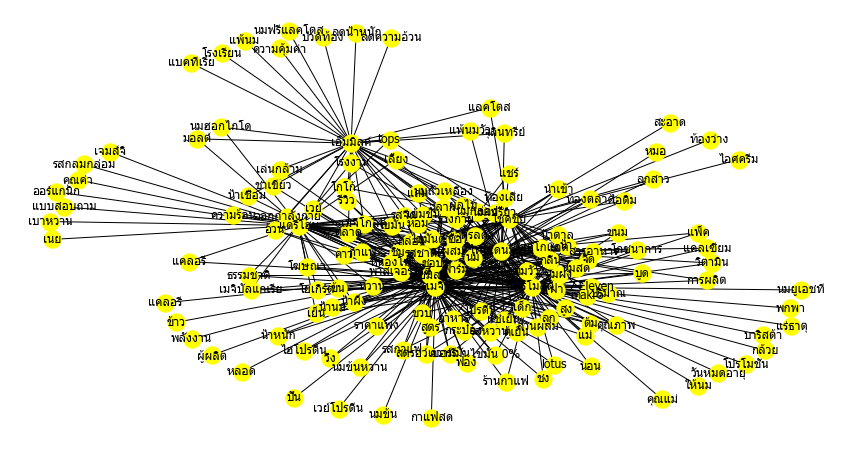

In [27]:
G2 = plot_pandas_graph(cooc_matrix_2_filter)

In [28]:
from community import community_louvain
partition = community_louvain.best_partition(G2)

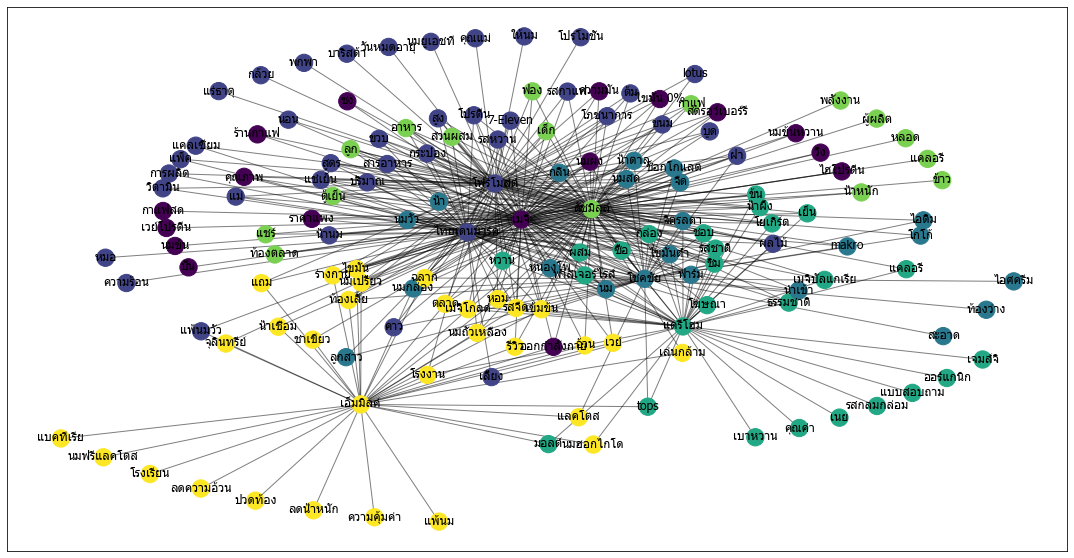

In [29]:
fig, ax=plt.subplots(figsize=(19,10))
G2=nx.from_pandas_edgelist(cooc_matrix_2_filter,source='item',target='relatedItem')
pos = nx.kamada_kawai_layout(G2)
nx.draw_networkx_nodes(G2,pos,partition.keys(),node_color=list(partition.values()))
nx.draw_networkx_edges(G2, pos, alpha=0.5)
nx.draw_networkx_labels(G2,pos,font_family='Tahoma')
plt.show()